<a href="https://colab.research.google.com/github/RozitaAbdoli/credit_default_mining/blob/main/Feature_selection_using_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.combine import SMOTETomek 

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import cv

In [ ]:
#Import Drive API and authenticate
from google.colab import drive
#Mount Drive to the Colab VM
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load the dataset into pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/Capstone_project/v2_credit_default.csv")

In [ ]:
#Seperate the independent and dependent variables.
X = df.drop(['Default'], axis=1)
y = df['Default']

In [ ]:
# train - test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [ ]:
# # define data_dmatrix
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
# Scale predictors 
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


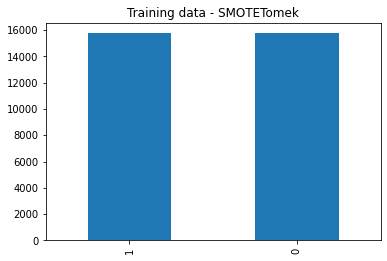

In [ ]:
# balancing the training data:
X_smt, y_smt = SMOTETomek(random_state=1).fit_sample(X_train_scaled, y_train.squeeze())
#Now to check the training data distribution is balanced:
pd.Series(y_smt.reshape(-1)).value_counts().plot(kind='bar', title='Training data - SMOTETomek');   

In [ ]:
# declare XGBooster parameters
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100
        }         
           
          
# instantiate the classifier 
xgb_clf = XGBClassifier(**params)


# fit the classifier to the training data
xgb_clf.fit(X_smt, y_smt)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=1.0, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# make predictions on test data
y_pred = xgb_clf.predict(X_test_scaled)

In [ ]:
# evaluation metrics
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('accuracy', accuracy_score(y_test, y_pred))
print('precision', precision_score(y_test, y_pred))
print('recall', recall_score(y_test, y_pred))

[[6294  687]
 [1203  806]]
accuracy 0.7897664071190211
precision 0.5398526456798393
recall 0.4011946241911399


In [ ]:
# cross validation with the metric: ROC AUC
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.745756,0.002224,0.742265,0.008418
1,0.765999,0.003481,0.760508,0.004745
2,0.770625,0.002431,0.764191,0.006001
3,0.772996,0.001932,0.765980,0.005666
4,0.776206,0.002038,0.769430,0.004860


In [ ]:
#In the preprocessing step (MinMaxScaler) columns names are lost and replaced by f1, f1, f2 etc...  Reintroduce names to the fitted model before plotting feature importance.
xgb_clf.get_booster().feature_names = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'Repay_Sept',
       'Repay_Aug', 'Repay_July', 'Repay_June', 'Repay_May', 'Repay_Apr',
       'Bill_Sept', 'Bill_Aug', 'Bill_July', 'Bill_June', 'Bill_May',
       'Bill_Apr', 'Pay_Sept', 'Pay_Aug', 'Pay_July', 'Pay_June', 'Pay_May',
       'Pay_Apr']

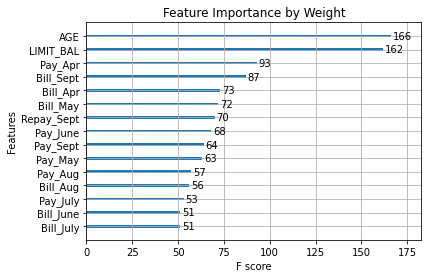

<Figure size 1872x1440 with 0 Axes>

In [ ]:
# Feature importnace by weight - top 15
xgb.plot_importance(xgb_clf, title='Feature Importance by Weight', max_num_features=15)    # by default, importance_type='weight' or the number of times the feature appears in a tree 
plt.figure(figsize = (26, 20))
plt.show()

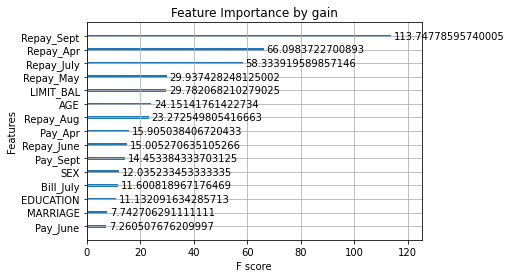

<Figure size 1872x1440 with 0 Axes>

In [ ]:
# Feature importnace by gain - top 15
xgb.plot_importance(xgb_clf, importance_type='gain', title='Feature Importance by gain', max_num_features=15)   #average gain of splits which use the feature  
plt.figure(figsize = (26, 20))
plt.show()